In [21]:
from pathlib import Path
import pandas as pd
import numpy as np
import os
import re
import regex

from fuzzywuzzy import process
from fuzzywuzzy import fuzz

In [3]:
data_dir = "/projects/robustmicrob/jlaw/projects/prot_stability_engineering/inputs/brenda"
ph_range_file = f"{data_dir}/ph_range/20230706_ph_range_data_fixes.tsv"
data = pd.read_table(ph_range_file)
data

,ec_num,uniprot_id,species,ph_min,ph_max,references,comments
0,1.1.1.1,B2KJ46,Candida parapsilosis,4.0,7.5,17435004,"#101# pH 4.0: about 80% of maximal activity, p..."
1,1.1.1.1,Q6L0S1,Picrophilus torridus,7.0,8.0,17989975,"#103# pH 7: 41% of maximal activity, pH 8: 59%..."
2,1.1.1.1,A4IP64,Geobacillus thermodenitrificans,6.0,9.0,"11893392,19383697",None
3,1.1.1.1,Q9HIM3,Thermoplasma acidophilum,2.0,8.0,19058034,None
4,1.1.1.1,P00330,Saccharomyces cerevisiae,5.5,9.0,21670533,"#131# reduction reaction activity range, profi..."
...,...,...,...,...,...,...,...
2995,7.2.2.9,O67203,Aquifex aeolicus,5.0,9.0,18374940,None
2996,7.2.2.9,O67432,Aquifex aeolicus,5.0,9.0,18374940,None
2997,7.3.2.1,O82390,Arabidopsis thaliana,5.5,8.5,18353780,None
2998,7.4.2.10,Q8ZQM4,Salmonella enterica subsp. enterica serovar Ty...,6.0,10.0,28691022,#9# over 60% of maximal activity within this r...


In [4]:
# Many entries don't have a uniprot ID. I attempted to map them using UniProt's ec number annotations
ph_range_file2 = f"{data_dir}/ph_range/ph_range_data_uniprot_ec.tsv"
data2 = pd.read_table(ph_range_file2)
data2

,ec_num,uniprot_id,species,ph_min,ph_max,references,comments
0,1.1.1.1,Q96XE0,Sulfurisphaera tokodaii,5.5,7.5,19139244,"#125# pH 5.5: about 35% of maximal activity, p..."
1,1.1.1.1,Q96XE0,Sulfurisphaera tokodaii,7.5,10.8,19139244,"#125# pH 7.5: about 35% of maximal activity, p..."
2,1.1.1.1,Q4J781,Sulfolobus acidocaldarius,6.7,8.5,20049620,"#126# pH 6.7: about 40% of maximal activity, p..."
3,1.1.1.1,Q4J781,Sulfolobus acidocaldarius,4.9,5.8,20049620,"#126# pH 4.9: about 25% of maximal activity, p..."
4,1.1.1.1,P28469,Macaca mulatta,9.0,12.0,7030395,"#45# pH 9.0: about 25% of maximal activity, pH..."
...,...,...,...,...,...,...,...
3654,7.2.2.10,P38929,Saccharomyces cerevisiae,5.5,8.0,9092527,#7# about 35% of maximal activity at pH 5.5 an...
3655,7.2.2.19,P19156,Sus scrofa,6.5,8.5,15749775,#6# at pH 6.5 30% and at pH 8.5 less than 1% o...
3656,7.2.2.19,P19156,Sus scrofa,6.8,7.8,2156097,"#6# pH 6.8: about 60% of maximal activity, pH ..."
3657,7.2.2.8,O29777,Archaeoglobus fulgidus,6.0,7.0,11756450,"#13# pH 6.0: about 30% of maximal activity, pH..."


In [5]:
data = pd.concat([data, data2]).drop_duplicates().reset_index(drop=True)
print(len(data))

5912


In [6]:
data = data[~data.comments.apply(lambda x: 'mutant' in x)]
len(data)

5842

In [7]:
data.comments.head().values

array(['#101# pH 4.0: about 80% of maximal activity, pH 7.5: about 60% of maximal activity <168>',
       '#103# pH 7: 41% of maximal activity, pH 8: 59% of maximal activity <173>',
       'None', 'None',
       '#131# reduction reaction activity range, profile overview <224>'],
      dtype=object)

In [8]:
len(data[data.species.apply(lambda x: "Escherichia coli" in x)])

146

In [9]:
data[data.species.apply(lambda x: "Escherichia coli" in x)]

,ec_num,uniprot_id,species,ph_min,ph_max,references,comments
141,1.1.1.380,Q8XB60,Escherichia coli,7.0,9.0,24861318,#4# the optimum pH for the activity with L-gal...
144,1.1.1.40,P76558,Escherichia coli,7.5,10.5,22068497,"#133# activity range, profile overview <86>"
153,1.1.1.414,Q8XB60,Escherichia coli,7.0,9.0,24861318,#2# the optimum pH for the activity with L-gal...
490,1.17.7.3,P62620,Escherichia coli,8.0,9.5,16268586,"#2# pH 8.0: about 65% of maximal activity, pH ..."
499,1.2.1.12,P0A9B2,Escherichia coli,8.0,10.5,32880588,#103# over 40% of maximal activity within this...
...,...,...,...,...,...,...,...
5666,4.4.1.13,P23256,Escherichia coli,7.2,9.0,7049234,"#6# pH 7.2: 36% of maximal activity, pH 8.0-9...."
5733,5.3.1.3,P69922,Escherichia coli,7.0,10.0,4632320,"#2# 7.0: sharp decrease in activity below, 8.0..."
5753,5.3.1.7,A0A6M7H989,Escherichia coli,6.0,9.5,796410,"#1# pH 6: about 35% of maximal activity, pH 9...."
5847,6.2.1.26,P37353,Escherichia coli,6.5,8.5,8955296,"#2# pH 6.5: 55% of maximal activity, pH 8.5: 8..."


In [10]:
data['comments'] = data.comments.replace("#\d+", "", regex=True) \
                                .replace("\d+#", "", regex=True) \
                                .replace("#", "", regex=True) \
                                .replace("<\d+>", "", regex=True)

In [49]:
def extract_ph_range_from_comment(comment, pattern, captures, error_limit=2):
    """
    *captures*: list of what is captured in each position
        e.g., ('act', 'ph', 'act', 'ph', 'ph') for 
        "about 40% activity at pH 6.5, more than 70% activity between pH 7.0 and 8.0"
    half-maximal and half-maximum will be replaced by 50%
    """
    comment = comment.replace("half-maximal", "50%") \
                     .replace("half-maximum", "50%") \
                     .replace("half-optima", "50%")
    # Rather than always allow errors, I found sometimes the regex would include an error even though it didn't have ti
    # first check the plain regular expression
    real_pattern = re.compile(pattern)
    extracted_vals = real_pattern.findall(comment)
    texts = [x.group() for x in real_pattern.finditer(comment)]
    matches = [[t] + (list(e) if isinstance(e, tuple) else [e])  for t, e in zip(texts, extracted_vals)]

    # now allow errors and see if more matches are found
    fuzzy_pattern = f'({pattern}){{e<={error_limit}}}'
    fuzzy_matches = regex.findall(fuzzy_pattern, comment)
    if len(fuzzy_matches) > len(matches):
        matches = fuzzy_matches
    
    def clean_number(x):
        x = x.replace(':', '').replace(' ','')
        if '%' in x:
            x = x.replace('%','')
            x = float(x) / 100
        return float(x)
    
    cleaned_matches = []
    # keep track of how much of the comment isn't captured by the regex
    leftover_comment = comment
    for m in matches:
        # find which indices are ph and which are activity
        opt_ph_idx = [i for i, c in enumerate(captures) if c == 'opt_ph']
        no_act_ph_idx = [i for i, c in enumerate(captures) if c == 'no_act_ph']
        ph_idx = [i for i, c in enumerate(captures) if c == 'ph']
        act_idx = [i for i, c in enumerate(captures) if c == 'act']
        # print(opt_ph_idx, ph_idx, act_idx)
        
        match = m[0]
        # make sure the semicolon is not skipped by the error matching
        if '):' in pattern and ':' not in match:
            continue
        # print(m)
        try:
            if len(opt_ph_idx) != 0:
                # just use 95% as the 'optimal' activity for now
                act = 0.95
                # if the pH is two values joined by '-'
                for ph in m[opt_ph_idx[0]+1].split('-'):
                    ph = clean_number(ph)
                    cleaned_matches.append((match, ph, act))
            if len(no_act_ph_idx) != 0:
                # this covers "no activity at pH X.X"
                act = 0
                ph = clean_number(m[no_act_ph_idx[0]+1])
                cleaned_matches.append((match, ph, act))
            if len(ph_idx) == 0 and len(act_idx) == 1:
                # "more than 95% of maximum activity"
                act = clean_number(m[1])
                cleaned_matches.append((match, None, act))
            elif len(ph_idx) == 1 and len(act_idx) == 1:
                ph = clean_number(m[ph_idx[0]+1])
                act = clean_number(m[act_idx[0]+1])
                cleaned_matches.append((match, ph, act))
            elif len(ph_idx) > len(act_idx):
                # "about 40% activity at pH 6.5, more than 70% activity between pH 7.0 and 8.0"
                curr_ph_idx = 0
                curr_act_idx = 0
                while curr_ph_idx < len(ph_idx):
                    # check if there are two phs next to each other
                    curr_idx = curr_ph_idx + curr_act_idx + len(opt_ph_idx)
                    # if the current capture index is at 'act',
                    # then the next two must be pHs
                    curr_idx += 1 if captures[curr_idx] != 'pH' else curr_idx
                    if (curr_idx + 1 < len(captures) and (
                        captures[curr_idx + 1] == 'ph' and 
                        captures[curr_idx] == 'ph')):
                        ph1 = clean_number(m[ph_idx[curr_ph_idx]+1])
                        curr_ph_idx += 1
                        ph2 = clean_number(m[ph_idx[curr_ph_idx]+1])
                        act = clean_number(m[act_idx[curr_act_idx]+1])
                        cleaned_matches.append((match, ph1, act))
                        cleaned_matches.append((match, ph2, act))
                    else:
                        ph = clean_number(m[ph_idx[curr_ph_idx]+1])
                        act = clean_number(m[act_idx[curr_act_idx]+1])
                        cleaned_matches.append((match, ph, act)) 
                    curr_ph_idx += 1
                    curr_act_idx += 1

            # if match_ph:
            #     match, ph, act = m
            #     ph = clean_number(ph)
            # else:
            #     match, act = m
            #     ph = None
            # act = clean_number(act)
            # cleaned_matches.append((match, ph, act))
            leftover_comment = leftover_comment.replace(match, "")
        except ValueError as e:
            # if we aren't able to cast the ph or activity level as a float,
            # then skip this entry
            print("Unable to extract float for one of the values:")
            print(m, comment)
    leftover_comment = leftover_comment.strip()
    # if there is a lot of comment still left after the matches, 
    # then this regex is not a good match for this comment
    if len(leftover_comment) > 60 and 'pH' in leftover_comment:
        good_match = False
        return good_match, matches, leftover_comment
            
    good_match = True if len(cleaned_matches) > 0 else False
    return good_match, cleaned_matches, leftover_comment

comment = "pH 7: about 41% of maximal activity, pH 8: 59% of maximal activity, oxidase activity"
# pattern = r"pH (\d+\.?\d*): [\s\w]*(\d\d%) [\s\w]*maximal activity,?"
pattern = r"pH (\d+\.?\d*): [about ]*(\d\d%) [\s\w]*maximal activity,?"

extract_ph_range_from_comment(comment, pattern, captures=['ph', 'act'])

(True,
 [('pH 7: about 41% of maximal activity,', 7.0, 0.41),
  ('pH 8: 59% of maximal activity,', 8.0, 0.59)],
 'oxidase activity')

In [10]:
# # testing patterns
# comments = ["more than 70% of maximum activity within",
#             # "more than 95% of maximum activity",
#             # "more than 60% activity between pH 5.0 and 8.0",
#             # "over 80% of amximal activity",
#             # "50% of maximum activity",
#             # "about 40% activity at pH 6.5, more than 70% activity between pH 7.0 and 8.0",
#             # "more than 60% of maximal activity between pH 7.5 and 8.5",
#             # "approx. a 20% of maximal activity at pH 6.5, approx. 90% of maximal activity at pH 9.0",
#             "about 55% activity at pH 7.0, 100% activity at pH around 8.0, about 80% activity at pH 9.0"
#            ]
# # pattern = r"[more than]*[over]*(\d\d%)[of ]*[maximumal]* activity,? ?"
# pattern = (r"[about ]*(\d+%)[of ]*[maximumal ]* activity[ is observed]*"
#            r" at pH[ around]* (\d+\.?\d*),? ?")
# fuzzy_pattern = f'({pattern}){{e<={1}}}'
# real_pattern = re.compile(pattern)
# for comment in comments:
#     print(regex.findall(fuzzy_pattern, comment))
#     extracted_vals = real_pattern.findall(comment)
#     texts = [x.group() for x in real_pattern.finditer(comment)]
#     matches = [[t] + (list(e) if isinstance(e, tuple) else [e])  for t, e in zip(texts, extracted_vals)]
#     print(matches)
#     # print(real_pattern.findall(comment))

In [12]:
def get_ph_act_from_comments(patterns, data, error_limit=1):
    """ Function to extract the pH activity from the Brenda comments fields 
    *patterns*: list of tuples with 1) regex pattern, 2) capture labels (e.g., ('ph', 'act'))
    *data*: dataframe with a 'comments' column
    """
    data_remaining = data.copy()
    all_results = []
    for pattern, captures in patterns:
        print('\n' + pattern)
        results = data_remaining.comments.apply(lambda x: extract_ph_range_from_comment(x, pattern, captures, error_limit=error_limit))
        # too_much_leftover = {i: (r, leftover) for i, (gm, r, leftover) in results.to_dict().items()
        #                      if gm is False and len(r) > 0}
        # print(len(too_much_leftover))
        # 
        matching_results = {i: (r, leftover) for i, (gm, r, leftover) in results.to_dict().items()
                            if gm}
        print(len(matching_results))
        if 'ph' in captures:
            table = [[i, ph, act, leftover] 
                 for i, (rs, leftover) in matching_results.items() 
                 for match, ph, act in rs]
        else:
            table = []
            for i, (rs, leftover) in matching_results.items():
                ph_min = data_remaining.loc[i].ph_min
                ph_min = float(ph_min) if ph_min is not None and ph_min != "None" else ph_min
                ph_max = data_remaining.loc[i].ph_max
                ph_max = float(ph_max) if ph_max is not None and ph_max != "None" else ph_max
                if ph_min == "None" and ph_max == "None":
                    continue
                    
                for match, _, act in rs:
                    table.append([i, ph_min, act, leftover])
                    table.append([i, ph_max, act, leftover])

        data_act = pd.DataFrame(table, columns=['exp_index', 'ph', 'activity', 'note'])
        print(data_act)
        data_act = data_act.replace("None", np.nan).dropna(subset=['ph'])
        data_act['note'] = data_act.note.replace("#\d+", "", regex=True) \
                                        .replace("\d+#", "", regex=True) \
                                        .replace("#", "", regex=True) \
                                        .replace("<\d+>", "", regex=True)
        data_act = data_act.sort_values("exp_index")
        print(len(data_act))


        all_results.append((data_act, matching_results))

        data_remaining = data_remaining[~data_remaining.index.isin(data_act.exp_index)]
        print(len(data_remaining), " data remaining")
        
    # TODO for activity range comments, give those a value of 10% (?)
    # may not always match
        
    all_data_act = pd.concat([da for da, _ in all_results])
    return all_data_act, all_results, data_remaining

In [44]:
# build the list of regex patterns 
activity_words = r"(?:about)?(?:over)?(?:approx\.)?(?:more than)?(?:less than)?"
observed_words = r"(?:is observed)?(?:remains)?(?:remaining)?(?:around)?(?:is maintained)?(?: from)? ?(?:between)?(?:within this)? ?"
maximum_words = r" ?(?:of )?(?:the )?(?:optimal)?(?:optimum)?(?:maximum)?(?:maximal)?(?:residual)? ?"
patterns = [
    # leave this pattern first since it seems to capture pretty specific cases
    (r"pH (\d+\.?\d*): [about ]*(\d+%)" + maximum_words + "activity,?", 
     ['ph', 'act']),
    # about 40% activity at pH 6.5, more than 70% activity between pH 7.0 and 8.0
    ((activity_words + r" ?(\d\d%)" + maximum_words + "activity[ is observed]* at pH (\d+\.?\d*), " +
      activity_words + r" ?(\d\d%)" + maximum_words + "activity " +
      r"[between]*[at]* pH (\d+\.?\d*) and [at ]*[pH ]*(\d+\.?\d*)"),
     ['act', 'ph', 'act', 'ph', 'ph']),
    # optimal activity at pH 8.0-9.0, 80% of maximal activity between pH 7.0 and pH 10.0
    ((r"optimal activity[ is observed]* at pH (\d+\.?\d*-?\d*\.?\d*), " +
      activity_words + r" ?(\d+%)" + maximum_words + "activity ?" +
      observed_words + r"[ at]* pH (\d+\.?\d*) and [at ]*[pH ]*(\d+\.?\d*)"),
     ['opt_ph', 'act', 'ph', 'ph']),
    # optimal activity at pH 8.0-9.0, 80% of maximal activity at pH 7.0
    ((r"optimal activity[ is observed]* at pH (\d+\.?\d*-?\d*\.?\d*), " +
      activity_words + r" ?(\d+%)" + maximum_words + "activity" +
      r"[ at]* pH (\d+\.?\d*)"),
     ['opt_ph', 'act', 'ph']),
    # 70% of maximum activity at pH 3, no activity at pH 7.5
    ((activity_words + r" ?(\d+%)" + maximum_words + "activity[ is observed]* [at]* pH (\d+\.?\d*), " +
      r"no activity at pH (\d+\.?\d*)"), 
     ['act', 'ph', 'no_act_ph']),
    # more than 60% of maximal activity between pH 7.5 and 8.5
    ((activity_words + r" ?(\d+%)" + maximum_words + "activity " +
      observed_words + r"[ at]* pH (\d+\.?\d*) and [at ]*[pH ]*(\d+\.?\d*)"), 
     ['act', 'ph', 'ph']),
    # about 55% activity at pH 7.0, 100% activity at pH around 8.0, about 80% activity at pH 9.0
    # ((r"[about]{4,5}?[over]{3,4}?[approx\.]{6,7}?[more than]{8,9}? ?(\d+%)[of ]*[maximumal ]* activity[ is observed]*"
    ((activity_words + r" ?(\d+%)" + maximum_words + "activity " +
    # ((r"[about ]*(\d++%)[of ]*[maximumal ]* activity[ is observed]*"
      observed_words + r"[ at]* pH[ around]* (\d+\.?\d*),? ?"),
     ['act', 'ph']),
    # 8.0-9.0: maximal activity, 10.5: 70% of maximal activity
    ((r"(\d+\.?\d*-?\d?\.?\d?): maximal activity, (\d+\.?\d*): (\d+%)" +
      maximum_words + "activity"),
     ['opt_ph', 'ph', 'act']),
    # 7.0: about 45% of maximal activity, 9.5: about 95% of maximal activity
    ((r"(\d+\.?\d*): " + activity_words + " ?(\d+%)" + maximum_words + "activity,?"),
     ['ph', 'act']),
    # over 70% of the maximum activity within this pH range
    ((activity_words + r" ?(\d+%)" + maximum_words + "activity " +
      observed_words + r"(?:pH ?)(?:range)"), 
     ['act']),
    # this is kind of the catch-all at the end
    # more than 95% of maximum activity
    # 50% of maximum activity
    (activity_words + r" ?(\d+%)" + maximum_words + "activity,? ?", ['act']),
]

In [56]:
# TODO automate these test cases
test_cases = [
    dict(ph_min=4.0, ph_max=7.5,
         comments="pH 4.0: about 80% of maximal activity, pH 7.5: about 60% of maximal activity",
         activities=[(4.0, 80), (7.5, 60)]),
    dict(ph_min=6.5, ph_max=8.0, 
         comments="about 40% activity at pH 6.5, more than 70% activity between pH 7.0 and 8.0",
         activities=[(6.5, 40), (7.0, 70), (8.0, 70)]),
    dict(ph_min=7.5, ph_max=8.5, 
         comments="more than 60% of maximal activity between pH 7.5 and 8.5",
         activities=[(7.5, 60), (8.5, 60)]),
    dict(ph_min=7.0, ph_max=9.0,
         comments="optimal activity at pH 8.0-9.0, 80% of maximal activity at pH 7.0", 
         activities=[(8.0, 95), (9.0, 95), (7.0, 80)]),
    dict(ph_min=7.0, ph_max=10.0,
         comments="optimal activity at pH 8.0-9.0, 80% of maximal activity at pH 7.0 and pH 10.0", 
         activities=[(8.0, 95), (9.0, 95), (7.0, 80), (10.0, 80)]),
    dict(ph_min=None, ph_max=None,
         comments="70% of maximum activity at pH 3, no activity at pH 7.5",
        activities=[(3.0, 70), (7.5, 0)]),
    # this comment would just use the pH listed in the 'ph_min' field
    dict(ph_min=7.0,
         comments="more than 95% of maximum activity",
         activities=[(7.0, 95)]),
    dict(ph_min=7.0, ph_max=10.0,
         comments="about 55% activity at pH 7.0, 100% activity at pH around 8.0, about 80% activity at pH 9.0, about 40% activity at pH 10.0",
         activities=[(7.0, 55), (8.0, 100), (9.0, 80), (10.0, 40)]),
    dict(ph_min=5.5, ph_max=9.5,
         comments="about 80% activity at pH 5.5, 100% activity at pH 6.5, about 90% activity at pH 7.5",
         activities=[(5.5, 80), (6.5, 100), (7.5, 90)]),
    #TODO: 68% of maximal activity at pH 6.3 and 88% at pH 8.8
    dict(ph_min=7.0, ph_max=9.5,
         comments="7.0: about 45% of maximal activity, 9.5: about 95% of maximal activity ",
         activities=[(7.0, 45), (9.5, 95)]),
    dict(ph_min=8.0, ph_max=10.5,
         comments="8.0-9.0: maximal activity, 10.5: 70% of maximal activity",
         activities=[(8.0, 95), (9.0, 95), (10.5, 70)]),
    dict(ph_min=5, ph_max=7,
         comments="about half-maximal activity at pH 5.0 and 7.0",
         activities=[(5, 50), (7, 50)]),
]

In [57]:
# test_data = pd.DataFrame(pd.Series([c for c, _ in test_cases]), columns=['comments'])
test_data = pd.DataFrame(test_cases)
test_data = test_data.tail(1)
test_data

,ph_min,ph_max,comments,activities
11,5.0,7.0,about half-maximal activity at pH 5.0 and 7.0,"[(5, 50), (7, 50)]"


In [58]:
test_data_act, test_results, test_data_remaining = get_ph_act_from_comments(patterns, test_data)
test_data_act


pH (\d+\.?\d*): [about ]*(\d+%) ?(?:of )?(?:the )?(?:optimal)?(?:optimum)?(?:maximum)?(?:maximal)?(?:residual)? ?activity,?
0
Empty DataFrame
Columns: [exp_index, ph, activity, note]
Index: []
0
1  data remaining

(?:about)?(?:over)?(?:approx\.)?(?:more than)?(?:less than)? ?(\d\d%) ?(?:of )?(?:the )?(?:optimal)?(?:optimum)?(?:maximum)?(?:maximal)?(?:residual)? ?activity[ is observed]* at pH (\d+\.?\d*), (?:about)?(?:over)?(?:approx\.)?(?:more than)?(?:less than)? ?(\d\d%) ?(?:of )?(?:the )?(?:optimal)?(?:optimum)?(?:maximum)?(?:maximal)?(?:residual)? ?activity [between]*[at]* pH (\d+\.?\d*) and [at ]*[pH ]*(\d+\.?\d*)
0
Empty DataFrame
Columns: [exp_index, ph, activity, note]
Index: []
0
1  data remaining

optimal activity[ is observed]* at pH (\d+\.?\d*-?\d*\.?\d*), (?:about)?(?:over)?(?:approx\.)?(?:more than)?(?:less than)? ?(\d+%) ?(?:of )?(?:the )?(?:optimal)?(?:optimum)?(?:maximum)?(?:maximal)?(?:residual)? ?activity ?(?:is observed)?(?:remains)?(?:remaining)?(?:around)?(?:is m

,exp_index,ph,activity,note
0,11,5.0,0.5,
1,11,7.0,0.5,


In [59]:
# now extract the ph activity data from the whole dataset
data_act, all_results, data_remaining = get_ph_act_from_comments(patterns, data)
data_act


pH (\d+\.?\d*): [about ]*(\d+%) ?(?:of )?(?:the )?(?:optimal)?(?:optimum)?(?:maximum)?(?:maximal)?(?:residual)? ?activity,?
Unable to extract float for one of the values:
('pH 5.8: about% of maximal activity,', '5.8', '%')  pH 5.8: about% of maximal activity, pH 8.8: about% of maximal activity 
Unable to extract float for one of the values:
('pH 8.8: about% of maximal activity', '8.8', '%')  pH 5.8: about% of maximal activity, pH 8.8: about% of maximal activity 
Unable to extract float for one of the values:
('pH 4.0: about % of maximal activity,', '4.0', '%')  pH 4.0: about % of maximal activity, pH 7.0: about % of maximal activity 
Unable to extract float for one of the values:
('pH 7.0: about % of maximal activity', '7.0', '%')  pH 4.0: about % of maximal activity, pH 7.0: about % of maximal activity 
Unable to extract float for one of the values:
('pH 2-5: about 70% of maximal activity', '2-5', '70%')  pH 1.2: about 50% of maximal activity, pH 2-5: about 70% of maximal activity 
U

,exp_index,ph,activity,note
0,0,4.0,0.80,
1,0,7.5,0.60,
2,1,7.0,0.41,
3,1,8.0,0.59,
4,7,5.5,0.35,reduction of benzaldehyde
...,...,...,...,...
1049,5759,8.8,0.50,in this range
1050,5772,6.0,0.50,above and below
1051,5772,8.7,0.50,above and below
1052,5807,5.0,0.90,within this range


In [18]:
data.head(2)

,ec_num,uniprot_id,species,ph_min,ph_max,references,comments
0,1.1.1.1,B2KJ46,Candida parapsilosis,4.0,7.5,17435004,"pH 4.0: about 80% of maximal activity, pH 7.5..."
1,1.1.1.1,Q6L0S1,Picrophilus torridus,7.0,8.0,17989975,"pH 7: 41% of maximal activity, pH 8: 59% of m..."


In [60]:
# add the full comment to data_act
data_act['ph_range_comment'] = data_act.exp_index.apply(lambda i: data.loc[i].comments)
data_act.head(2)

,exp_index,ph,activity,note,ph_range_comment
0,0,4.0,0.8,,"pH 4.0: about 80% of maximal activity, pH 7.5..."
1,0,7.5,0.6,,"pH 4.0: about 80% of maximal activity, pH 7.5..."


In [134]:
# add the manually parsed data and manually fixed data
manual_data_act_file = Path(data_dir, "ph_range/20230719_fixed_manual.csv")
manual_data_act = pd.read_csv(manual_data_act_file)
manual_data_act.dropna(subset=['activity'], inplace=True)
print(manual_data_act.exp_index.nunique(), len(manual_data_act))
manual_data_act.head(2)

203 484


,exp_index,ph,activity,note,ph_range_comment
0,1850,6.0,1.0,soluble enzyme,"less than 10% of maximal activity at pH 5.5, ..."
1,1850,7.5,0.6,soluble enzyme,"less than 10% of maximal activity at pH 5.5, ..."


In [135]:
print(data_act.exp_index.nunique(), len(data_act))
data_act = data_act[~data_act.exp_index.isin(manual_data_act.exp_index)]
print(data_act.exp_index.nunique(), len(data_act))
data_act = pd.concat([data_act, manual_data_act], ignore_index=True).reset_index(drop=True)
print(data_act.exp_index.nunique(), len(data_act))

2446 4829
2243 4345
2446 4829


In [68]:
data_act.head(2)

,exp_index,ph,activity,note,ph_range_comment
0,0,4.0,0.8,,"pH 4.0: about 80% of maximal activity, pH 7.5..."
1,0,7.5,0.6,,"pH 4.0: about 80% of maximal activity, pH 7.5..."


In [136]:
# write to file
out_file = Path(data_dir, "ph_range/20230719_ph_range_processed_act.csv")
print(out_file)
data_act.to_csv(out_file, index=False)

out_file = Path(data_dir, "ph_range/20230719_ph_range_processed.csv")
print(out_file)
data.to_csv(out_file, index="exp_index")

/projects/robustmicrob/jlaw/projects/prot_stability_engineering/inputs/brenda/ph_range/20230719_ph_range_processed_act.csv
/projects/robustmicrob/jlaw/projects/prot_stability_engineering/inputs/brenda/ph_range/20230719_ph_range_processed.csv


In [78]:
# also write the uniprot IDs
uniprot_ids = data[data.index.isin(data_act.exp_index)].uniprot_id.unique()
print(len(uniprot_ids))
out_file_ids = str(out_file).replace('.csv', '_uniprot_ids.txt')
print(out_file_ids)
with open(out_file_ids.replace('.csv', '_uniprot_ids.txt'), 'w') as out:
    out.write('\n'.join(uniprot_ids) + '\n')
# uniprot_ids.to_csv(out_file.replace('.csv', '_uniprot_ids.txt'))

2125
/projects/robustmicrob/jlaw/projects/prot_stability_engineering/inputs/brenda/ph_range/20230719_ph_range_processed_uniprot_ids.txt


In [40]:
data_remaining.head(2)

,ec_num,uniprot_id,species,ph_min,ph_max,references,comments,ec_num_link
2,1.1.1.1,A4IP64,Geobacillus thermodenitrificans,6.0,9.0,"11893392,19383697",None,https://www.brenda-enzymes.org/enzyme.php?ecno...
3,1.1.1.1,Q9HIM3,Thermoplasma acidophilum,2.0,8.0,19058034,None,https://www.brenda-enzymes.org/enzyme.php?ecno...


In [39]:
data_remaining['ec_num_link'] = data_remaining['ec_num'].apply(lambda ec_num: f"https://www.brenda-enzymes.org/enzyme.php?ecno={ec_num}#pH%20RANGE")

In [79]:
# write to file
out_file = Path(data_dir, "20230719_ph_range_data_remaining.csv")
print(out_file)
data_remaining.to_csv(out_file, index="exp_index")

/projects/robustmicrob/jlaw/projects/prot_stability_engineering/inputs/brenda/20230719_ph_range_data_remaining.csv


In [20]:
data_act.exp_index.value_counts()

1694    10
5723     8
2317     7
5475     7
5476     7
        ..
3698     1
279      1
278      1
221      1
4070     1
Name: exp_index, Length: 2105, dtype: int64

In [ ]:
data.loc[5890].comments

' 7.2-7.7: maximal activity, 8.4: 50% of maximal activity '

In [580]:
print(len(data_act[data_act.note.apply(lambda x: 'pH' in x)]))
data_act[data_act.note.apply(lambda x: 'pH' in x)].head(100).tail(50)

132


,exp_index,ph,activity,note
235,2350,9.0,0.50,", the enzyme is inactive at pH 6.0 and 10.0"
246,2481,6.0,0.60,% activity at pH 8.0 in 10 mM sodium phosphate
247,2481,80.0,0.60,% activity at pH 8.0 in 10 mM sodium phosphate
256,2690,8.5,0.90,", 30% at pH 7.5, inactive below, profile overv..."
257,2690,10.0,0.90,", 30% at pH 7.5, inactive below, profile overv..."
262,2907,5.0,0.50,"over 70% of maximal activity at pH 5.5-9.0,"
263,2907,9.5,0.50,"over 70% of maximal activity at pH 5.5-9.0,"
8,172,6.0,0.50,"the enzyme shows aroundpH 6.5, and pH 8.0"
10,299,4.0,0.04,"activity range, 53.18.4% at pH 3.0"
11,368,10.0,0.10,"almost no activity at pH 4.5, i.e. a second o..."


In [583]:
data_remaining[data_remaining.comments.apply(lambda x: 'activity range' in x)]

,ec_num,uniprot_id,species,ph_min,ph_max,references,comments
4,1.1.1.1,P00330,Saccharomyces cerevisiae,5.5,9.0,21670533,"#131# reduction reaction activity range, profi..."
18,1.1.1.103,E5RQ20,Cupriavidus necator,6.0,12.0,21073854,"#26# activity range, pH-dependent activity var..."
23,1.1.1.12,Q96V44,Trichoderma reesei,6.5,10.0,NaN,"#11# activity range, immobilized recombinant e..."
25,1.1.1.12,Q96V44,Trichoderma reesei,7.0,10.0,NaN,"#11# activity range, free recombinant enzyme, ..."
26,1.1.1.12,Q96V44,Trichoderma reesei,6.0,10.0,24193245,#11# activity range of both free and immobiliz...
...,...,...,...,...,...,...,...
2944,6.3.1.2,E9B8P8,Leishmania donovani,6.0,11.0,28351708,#197# activity range <241>
2949,6.3.1.9,Q8IFU8,Leishmania donovani,6.0,10.0,24901644,"#13# activity range, profile overview <24>"
2954,6.3.2.29,M9UYB0,uncultured bacterium,7.0,11.0,23579730,"#16# activity range, high activity at a pH ran..."
2955,6.3.2.30,M9UYB0,uncultured bacterium,7.0,11.0,23579730,"#20# activity range, high activity at a pH ran..."


In [86]:
data_act.exp_index.value_counts()

1694    10
5475     7
2317     7
5476     7
2322     6
        ..
1371     1
1367     1
2116     1
2142     1
16       1
Name: exp_index, Length: 2446, dtype: int64

In [87]:
data2 = data[data.index.isin(data_act.exp_index)]
len(data2)

2446

In [80]:
# also load the ph optimum
data_opt = pd.read_table(f"{data_dir}/ph_opt_data_no_assay_at_no_mutant.tsv")
print(len(data_opt))
data_opt.head(2)

8367


,ec_num,uniprot_id,opt,species,references,comments
0,1.1.1.1,D4GSN2,11.0,Haloferax volcanii,"7011375,3816781,2789998,22526808","#82# oxidation of ethanol, pyrazole-insensitiv..."
1,1.1.1.1,D4GSN2,6.0,Haloferax volcanii,"12834271,16000771,17072683,16390205,16243283,1...","#96,122# reduction of acetaldehyde <144,255>; ..."


In [88]:
data_opt_match = data_opt[data_opt.uniprot_id.isin(data2.uniprot_id.unique())]
print(len(data_opt_match))
data_opt_match.head(2)

1362


,ec_num,uniprot_id,opt,species,references,comments
14,1.1.1.1,Q4J702,5.1,Sulfolobus acidocaldarius,20049620,#126# reduction reaction <218>; #127# reductio...
15,1.1.1.1,Q4J702,8.2,Sulfolobus acidocaldarius,"7011375,4455216,20049620","#82# and a second optimum at pH 10.6, oxidatio..."


In [82]:
matching_df[matching_df.uniprot_id == "Q4J702"]

NameError: name 'matching_df' is not defined

In [102]:
data_opt_match[data_opt_match.uniprot_id == data.loc[5381].uniprot_id]

,ec_num,uniprot_id,opt,species,references,comments
3753,3.6.1.13,Q9UKK9,10.0,Homo sapiens,21389046,#14# for cleavage of 8-oxo-dGDP <35>
3754,3.6.1.13,Q9UKK9,6.5-9.0,Homo sapiens,10722730,#14# activity at pH 8.0 is about 90% of the ac...
3755,3.6.1.13,Q9UKK9,7.4-9.0,Homo sapiens,10567213,#14# with 2.5-5 mM Mg2+ or 0.1-0.25 mM Mn2+ <13>
3756,3.6.1.13,Q9UKK9,7.0,Homo sapiens,"10722730,18462755",#14# activity with ADP-mannose <19>
3757,3.6.1.13,Q9UKK9,7.0-9.0,Homo sapiens,"7819284,21389046",#5# ADPRibase I and ADPRibase II <10>; #14# fo...


In [137]:
# see if we can get the ph optimum automatically
opt_not_in_range = []
more_data = []
more_than_2_count = 0
for exp_idx, df in data_act.groupby("exp_index"):
    note = df.note.unique()[0]
    row = data.loc[exp_idx]
    df2 = data_opt_match[(data_opt_match.uniprot_id == row.uniprot_id) & 
                         (data_opt_match.ec_num == row.ec_num)]
    if len(df2) == 0:
        continue
    # if len(df2) > 1:
    #     more_than_2_count += 1
    #     # skip for now
    #     continue
    ph_opts = [ph for phs in df2.opt.values for ph in phs.split('-')]
    for ph_opt in ph_opts:
        ph_opt = float(ph_opt)
        if len(df) == 1 or (
            df.ph.min() < ph_opt and df.ph.max() > ph_opt):
            # ph_opt is in range. Add to data
            # TODO make sure the exp_index is for the same paper
            more_data += [[exp_idx, ph_opt, 1.0, '']]
        else:
            print(df.values, ph_opts)
            opt_not_in_range.append((exp_idx, ph_opts))
            continue
print(f"{len(more_data) = }, {len(opt_not_in_range) = }, {more_than_2_count = }")

[[7 5.5 0.35 'reduction of benzaldehyde'
  ' pH 5.5: about 35% of maximal activity, pH 7.5: about 55% of maximal activity, reduction of benzaldehyde ']
 [7 7.5 0.55 'reduction of benzaldehyde'
  ' pH 5.5: about 35% of maximal activity, pH 7.5: about 55% of maximal activity, reduction of benzaldehyde ']] ['10.5', '7.0']
[[8 7.5 0.35 'oxidation of 1-hexanol'
  ' pH 7.5: about 35% of maximal activity, pH 10.8: about 50% of maximal activity, oxidation of 1-hexanol ']
 [8 10.8 0.5 'oxidation of 1-hexanol'
  ' pH 7.5: about 35% of maximal activity, pH 10.8: about 50% of maximal activity, oxidation of 1-hexanol ']] ['10.5', '7.0']
[[9 6.7 0.4 'oxidation reaction'
  ' pH 6.7: about 40% of maximal activity, pH 8.5: about 85% of maximal activity, oxidation reaction ']
 [9 8.5 0.85 'oxidation reaction'
  ' pH 6.7: about 40% of maximal activity, pH 8.5: about 85% of maximal activity, oxidation reaction ']] ['5.1', '8.2']
[[10 4.9 0.25 'reduction reaction'
  ' pH 4.9: about 25% of maximal activity,

Without ec num:
- len(more_data) = 1693, len(opt_not_in_range) = 261

with ec num:
- len(more_data) = 1512, len(opt_not_in_range) = 232

In [138]:
ph_opts = pd.DataFrame(more_data, columns=['exp_index', 'ph', 'activity', 'note'])
print(len(ph_opts))
ph_opts

1512


,exp_index,ph,activity,note
0,0,4.5,1.0,
1,7,7.0,1.0,
2,8,10.5,1.0,
3,9,8.2,1.0,
4,10,5.1,1.0,
...,...,...,...,...
1507,5788,8.5,1.0,
1508,5863,8.0,1.0,
1509,5864,7.6,1.0,
1510,5864,7.4,1.0,


In [139]:
ph_opts.exp_index.value_counts()

211     10
2566     7
4959     7
2495     7
2496     7
        ..
1159     1
1184     1
1186     1
1195     1
5896     1
Name: exp_index, Length: 1099, dtype: int64

In [140]:
ph_opts[ph_opts.exp_index == 217]

,exp_index,ph,activity,note
114,217,7.0,1.0,
115,217,7.5,1.0,
116,217,8.0,1.0,


In [106]:
data.loc[5431]

ec_num                                                 4.1.1.18
uniprot_id                                               O50657
species                                 Selenomonas ruminantium
ph_min                                                      7.0
ph_max                                                      8.0
references                                              6401702
comments       pH 7.0: about 70% of maximal activity, pH 9.0...
Name: 5431, dtype: object

In [105]:
data_act[data_act.exp_index == 5381]

,exp_index,ph,activity,note,ph_range_comment
1776,5381,9.5,0.5,,"pH 9.5: about 50% of maximal activity, pH 12...."
1777,5381,12.0,0.5,,"pH 9.5: about 50% of maximal activity, pH 12...."


In [104]:
ph_opts[ph_opts.exp_index == 5381]

,exp_index,ph,activity,note
1666,5381,10.0,1.0,


In [115]:
data_act

,exp_index,ph,activity,note,ph_range_comment
0,0,4.0,0.80,,"pH 4.0: about 80% of maximal activity, pH 7.5..."
1,0,7.5,0.60,,"pH 4.0: about 80% of maximal activity, pH 7.5..."
2,1,7.0,0.41,,"pH 7: 41% of maximal activity, pH 8: 59% of m..."
3,1,8.0,0.59,,"pH 7: 41% of maximal activity, pH 8: 59% of m..."
4,7,5.5,0.35,reduction of benzaldehyde,"pH 5.5: about 35% of maximal activity, pH 7.5..."
...,...,...,...,...,...
4824,1633,8.0,0.40,NaN,NaN
4825,1640,13.0,0.00,NaN,"activity range, inactive at pH 13 and pH 1.0"
4826,1640,1.0,0.00,NaN,NaN
4827,1640,2.0,0.10,NaN,NaN


In [141]:
data_act2 = pd.concat([data_act, ph_opts], ignore_index=True).reset_index(drop=True)
data_act2.sort_values('exp_index', inplace=True)
print(len(data_act), len(data_act2))
# print(data_act2.uniprot_id.nunique(), len(data_act2))
data_act2.head(10)

4829 6341


,exp_index,ph,activity,note,ph_range_comment
0,0,4.0,0.80,,"pH 4.0: about 80% of maximal activity, pH 7.5..."
4829,0,4.5,1.00,,NaN
1,0,7.5,0.60,,"pH 4.0: about 80% of maximal activity, pH 7.5..."
2,1,7.0,0.41,,"pH 7: 41% of maximal activity, pH 8: 59% of m..."
3,1,8.0,0.59,,"pH 7: 41% of maximal activity, pH 8: 59% of m..."
4,7,5.5,0.35,reduction of benzaldehyde,"pH 5.5: about 35% of maximal activity, pH 7.5..."
5,7,7.5,0.55,reduction of benzaldehyde,"pH 5.5: about 35% of maximal activity, pH 7.5..."
4830,7,7.0,1.00,,NaN
6,8,7.5,0.35,oxidation of 1-hexanol,"pH 7.5: about 35% of maximal activity, pH 10...."
7,8,10.8,0.50,oxidation of 1-hexanol,"pH 7.5: about 35% of maximal activity, pH 10...."


In [142]:
# write to file
out_file = Path(data_dir, "ph_range/20230719_ph_range_processed_act_wopt.csv")
print(out_file)
data_act2.to_csv(out_file, index=False)

/projects/robustmicrob/jlaw/projects/prot_stability_engineering/inputs/brenda/ph_range/20230719_ph_range_processed_act_wopt.csv


In [106]:
data_act2 = data_act2[data_act2.ph < 12]
data_act2 = data_act2[data_act2.activity <= 1]

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns

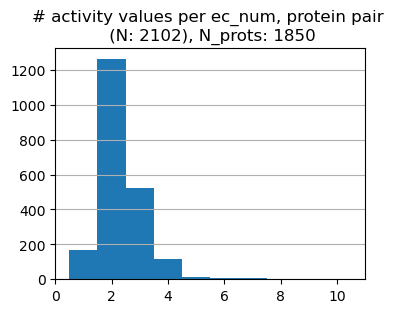

In [114]:
f, ax = plt.subplots(figsize=(4,3))
ax.set_title(f"# activity values per ec_num, protein pair \n (N: {data_act2.exp_index.nunique()}), N_prots: {data2.uniprot_id.nunique()}")
data_act2.exp_index.value_counts().hist(bins=np.arange(0.5,11,1))
ax.grid(visible=False, axis='x')

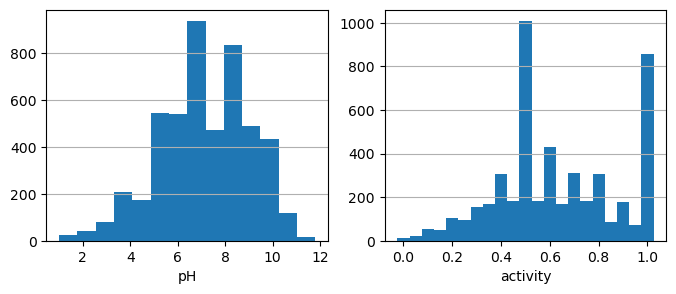

In [115]:

f, (ax, ax2) = plt.subplots(ncols=2, figsize=(8,3))
# ax.set_title(f"# activity values per ec_num, protein pair \n (N: {data_act2.exp_index.nunique()}), N_prots: {data2.uniprot_id.nunique()}")
# data_act2.ph.hist(bins=np.arange(0.1, 14
data_act2.ph.hist(bins=14, ax=ax)
ax.set_xlabel('pH')
ax.grid(visible=False, axis='x')

data_act2.activity.hist(bins=np.arange(-0.025,1.03,0.05), ax=ax2)
ax2.set_xlabel('activity')
ax2.grid(visible=False, axis='x')

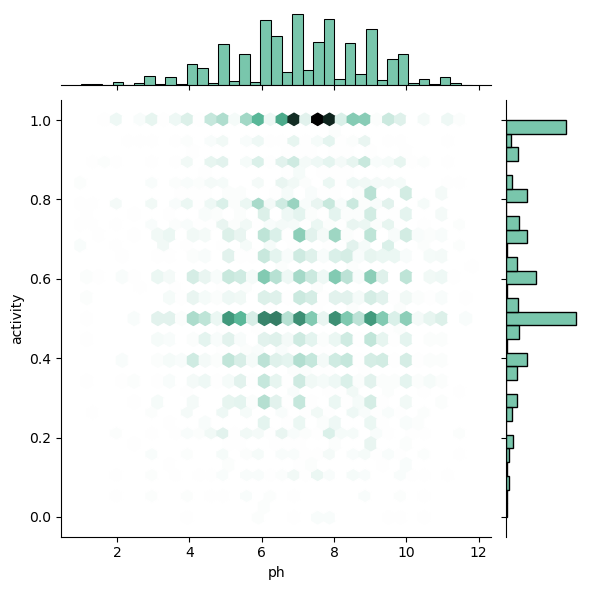

In [119]:
sns.jointplot(data_act2, x='ph', y='activity',
              kind="hex", color="#4CB391",
             )

<AxesSubplot: xlabel='ph', ylabel='activity'>

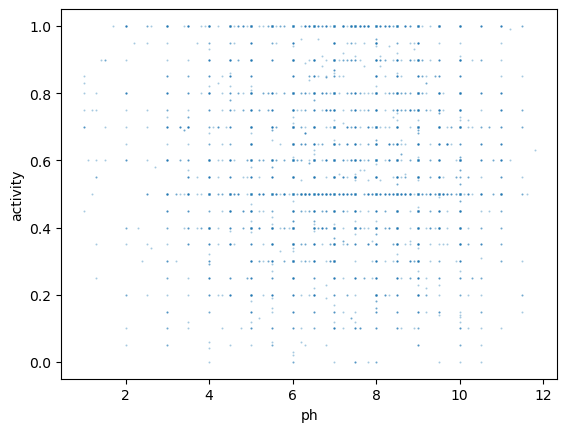

In [118]:
sns.scatterplot(data_act2, x='ph', y='activity',
                s=2, alpha=0.4,
                # style='hex',
               )